# Toxicity Classification in Online Comments

In the age of social media, it's difficult for developers to monitor every single remark, blog. People utilise this platform to share and learn information at times. However, some people use toxic remarks that are insulting, vulgar, and can cause some people to abandon the debate. As a result, many individuals stop expressing themselves and stop searching out alternative viewpoints. Because platforms fail to properly facilitate dialogues, several communities limit or totally disable user comments.

In this notebook several machine learning algorithms are applied to the jicksaw text data and their performance in terms of Accuracy is compared. Models considered are naive-Bayes, MLP Classifier and Random Forest and their performance is evaluated using accuracy metric. An aspect considered here is the inbalance of class frequencies. While for most algorithms in this notebook a feature matrix based on weights of particular words of the comment-text is employed (TF-idf).

### Data Source

At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.
 The data is downloaded from Kaggle and this <a href="https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data">link</a> will take you to the page on kaggle where you can download the data.

### Import necessary libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from numpy.random import RandomState
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

### Import data into dataframes

In [12]:
# train_emb_data = pd.read_csv("dataset/train_embedding.csv")
train_raw_data = pd.read_csv("dataset/train_raw.csv")
train_tfidf_data = pd.read_csv("dataset/train_tfidf.csv")
# dev_emb_data = pd.read_csv("dataset/dev_embedding.csv")
# dev_raw_data = pd.read_csv("dataset/dev_raw.csv")
dev_tfidf_data = pd.read_csv("dataset/dev_tfidf.csv")
# test_emb_data = pd.read_csv("dataset/test_embedding.csv")
# test_raw_data = pd.read_csv("dataset/test_raw.csv")
test_tfidf_data = pd.read_csv("dataset/test_tfidf.csv")
# unlabeled_emb_data = pd.read_csv("dataset/unlabeled_embedding.csv")
# unlabeled_raw_data = pd.read_csv("dataset/unlabeled_raw.csv")
# unlabeled_tfidf_data = pd.read_csv("dataset/unlabeled_tfidf.csv")

## Dataset

Using only raw training data for analysis.

In [393]:
# Showing first few rows of raw data
train_raw_data.head()

ID  Toxicity  Asian  Atheist  Bisexual  Black  Buddhist  Christian  Female  \
0   0         0      0        0         0      0         0          0       0   
1   1         1      0        0         0      0         0          1       0   
2   2         1      0        0         0      0         0          0       1   
3   3         0      0        0         0      0         0          0       0   
4   4         0      0        0         0      0         0          1       0   

   Heterosexual  ...  Other disability  Other gender  Other race or ethnicity  \
0             0  ...                 0             0                        0   
1             0  ...                 0             0                        0   
2             0  ...                 0             0                        0   
3             0  ...                 0             0                        0   
4             0  ...                 0             0                        0   

   Other religion  Other sexual orientation  Physical disability  \
0               0                         0                    0   
1               0                         0                    0   
2               0                         0                    0   
3               0                         0                    0   
4               0                         0                    0   

   Psychiatric or mental illness  Transgender  White  \
0                              0            0      0   
1                              0            0      0   
2                              0            0      0   
3                              1            0      0   
4                              0            0      0   

                                             Comment  
0  This is a great story. Man. I wonder if the pe...  
1  Yet call out all Muslims for the acts of a few...  
2  This bitch is nuts. Who would read a book by a...  
3  I think you left out one very important organi...  
4  Should they have to? \n\nChristians, whether a...  

[5 rows x 27 columns]

In [394]:
# showing information of raw training data
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140000 entries, 0 to 139999
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   ID                                   140000 non-null  int64 
 1   Toxicity                             140000 non-null  int64 
 2   Asian                                140000 non-null  int64 
 3   Atheist                              140000 non-null  int64 
 4   Bisexual                             140000 non-null  int64 
 5   Black                                140000 non-null  int64 
 6   Buddhist                             140000 non-null  int64 
 7   Christian                            140000 non-null  int64 
 8   Female                               140000 non-null  int64 
 9   Heterosexual                         140000 non-null  int64 
 10  Hindu                                140000 non-null  int64 
 11  Homosexual gay or lesbian 

In [395]:
# displaying shape of raw training data
train_raw_data.shape

(140000, 27)

In [396]:
# statistical info of dataset
train_raw_data.describe()

ID       Toxicity          Asian        Atheist  \
count  140000.000000  140000.000000  140000.000000  140000.000000   
mean    69999.500000       0.160614       0.027821       0.007714   
std     40414.663181       0.367176       0.164462       0.087492   
min         0.000000       0.000000       0.000000       0.000000   
25%     34999.750000       0.000000       0.000000       0.000000   
50%     69999.500000       0.000000       0.000000       0.000000   
75%    104999.250000       0.000000       0.000000       0.000000   
max    139999.000000       1.000000       1.000000       1.000000   

            Bisexual          Black       Buddhist      Christian  \
count  140000.000000  140000.000000  140000.000000  140000.000000   
mean        0.001579       0.080279       0.003443       0.244021   
std         0.039700       0.271725       0.058575       0.429507   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              Female   Heterosexual  ...         Muslim  Other disability  \
count  140000.000000  140000.000000  ...  140000.000000     140000.000000   
mean        0.307636       0.007143  ...       0.130350          0.000036   
std         0.461517       0.084213  ...       0.336689          0.005976   
min         0.000000       0.000000  ...       0.000000          0.000000   
25%         0.000000       0.000000  ...       0.000000          0.000000   
50%         0.000000       0.000000  ...       0.000000          0.000000   
75%         1.000000       0.000000  ...       0.000000          0.000000   
max         1.000000       1.000000  ...       1.000000          1.000000   

        Other gender  Other race or ethnicity  Other religion  \
count  140000.000000            140000.000000   140000.000000   
mean        0.000064                 0.002914        0.001936   
std         0.008018                 0.053906        0.043954   
min         0.000000                 0.000000        0.000000   
25%         0.000000                 0.000000        0.000000   
50%         0.000000                 0.000000        0.000000   
75%         0.000000                 0.000000        0.000000   
max         1.000000                 1.000000        1.000000   

       Other sexual orientation  Physical disability  \
count             140000.000000        140000.000000   
mean                   0.000050             0.000493   
std                    0.007071             0.022195   
min                    0.000000             0.000000   
25%                    0.000000             0.000000   
50%                    0.000000             0.000000   
75%                    0.000000             0.000000   
max                    1.000000             1.000000   

       Psychiatric or mental illness    Transgender          White  
count                  140000.000000  140000.000000  140000.000000  
mean                        0.028286       0.015714       0.144443  
std                         0.165789       0.124368       0.351539  
min                         0.000000       0.000000       0.000000  
25%                         0.000000       0.000000       0.000000  
50%                         0.000000       0.000000       0.000000  
75%                         0.000000       0.000000       0.000000  
max                         1.000000       1.000000       1.000000  

[8 rows x 26 columns]

In [397]:
cmt_check = train_raw_data[train_raw_data['Comment'].isnull()]
len(cmt_check)

0

## Basic Exploratory Data Analysis

**Distribution for words in comment text**

In [398]:
train_raw_data['num_words'] = [len(sent.split()) for sent in train_raw_data['Comment']]
train_raw_data[['Comment', 'num_words']].head()

Comment  num_words
0  This is a great story. Man. I wonder if the pe...         22
1  Yet call out all Muslims for the acts of a few...         39
2  This bitch is nuts. Who would read a book by a...         12
3  I think you left out one very important organi...        118
4  Should they have to? \n\nChristians, whether a...         61

In [399]:
# maximum and minimum number of words per sentencs
max(train_raw_data['num_words']), min(train_raw_data['num_words'])

(228, 1)

In [400]:
train_raw_data['toxic'] = np.where(train_raw_data['Toxicity'] >= .5, 'Toxic', 'Non-Toxic')

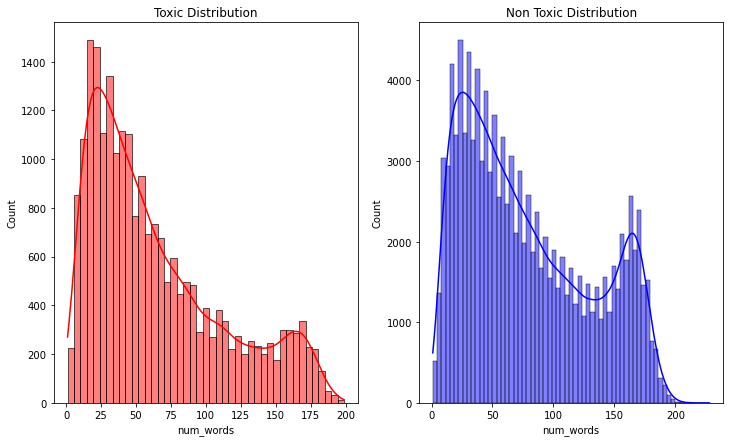

In [401]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
sns.histplot(train_raw_data[train_raw_data['toxic'] == 'Toxic']['num_words'], kde= True, ax=ax[0], color= 'r')
sns.histplot(train_raw_data[train_raw_data['toxic'] == 'Non-Toxic']['num_words'], kde= True, ax=ax[1], color= 'b')
ax[0].set_title("Toxic Distribution")
ax[1].set_title("Non Toxic Distribution")
plt.show()

**Distribuition of Toxicity of comments**

In [402]:
train_raw_data['toxic'].value_counts()

Non-Toxic    117514
Toxic         22486
Name: toxic, dtype: int64

Text(0.5, 1.0, 'Distribuition of Toxicity of comments')

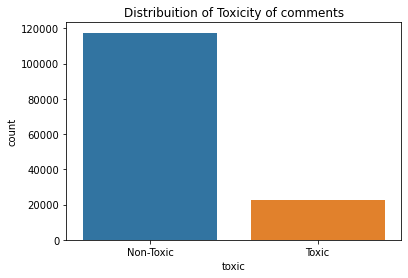

In [403]:
sns.countplot(train_raw_data['toxic'])
plt.title('Distribuition of Toxicity of comments')

In [404]:
# lets create a list of all the identities tagged in this dataset.
identities = ['Asian', 'Atheist', 'Bisexual', 'Black', 'Buddhist',
       'Christian', 'Female', 'Heterosexual', 'Hindu',
       'Homosexual gay or lesbian', 'Intellectual or learning disability',
       'Jewish', 'Latino', 'Male', 'Muslim', 'Other disability',
       'Other gender', 'Other race or ethnicity', 'Other religion',
       'Other sexual orientation', 'Physical disability',
       'Psychiatric or mental illness', 'Transgender', 'White']

In [405]:
# getting the dataframe with identities tagged
train_labeled_df = train_raw_data.loc[:, ['Toxicity'] + identities ].dropna()

# lets define toxicity as a comment with a score being equal or .5
toxic_df = train_labeled_df[train_labeled_df['Toxicity'] >= .5][identities]
non_toxic_df = train_labeled_df[train_labeled_df['Toxicity'] < .5][identities]

In [406]:
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.
toxic_count = toxic_df.apply(lambda x : x > 0 ).sum()
non_toxic_count = non_toxic_df.apply(lambda x : x > 0 ).sum()

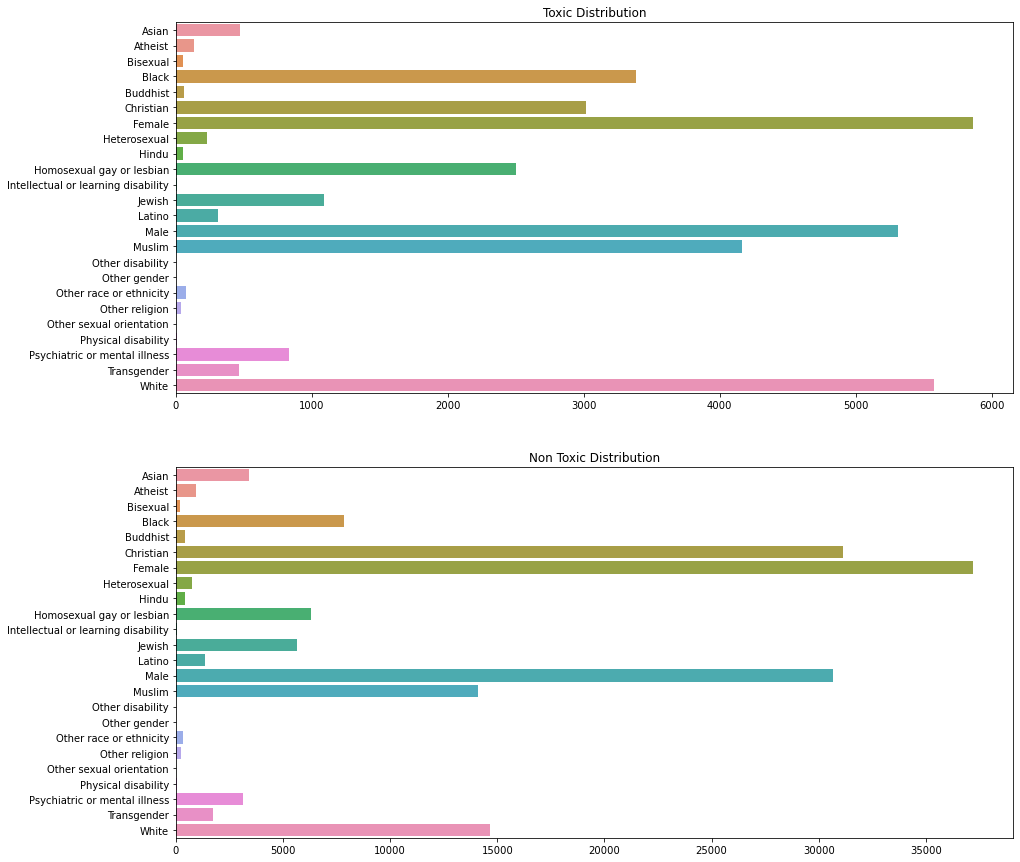

In [407]:
fig, ax = plt.subplots(nrows= 2,ncols= 1,figsize=(15,15))

sns.barplot(x= toxic_count, y= identities, ax=ax[0])
sns.barplot(x= non_toxic_count, y= identities, ax=ax[1])

ax[0].set_title("Toxic Distribution")
ax[1].set_title("Non Toxic Distribution")
plt.show()

## Preprocessing data for model training

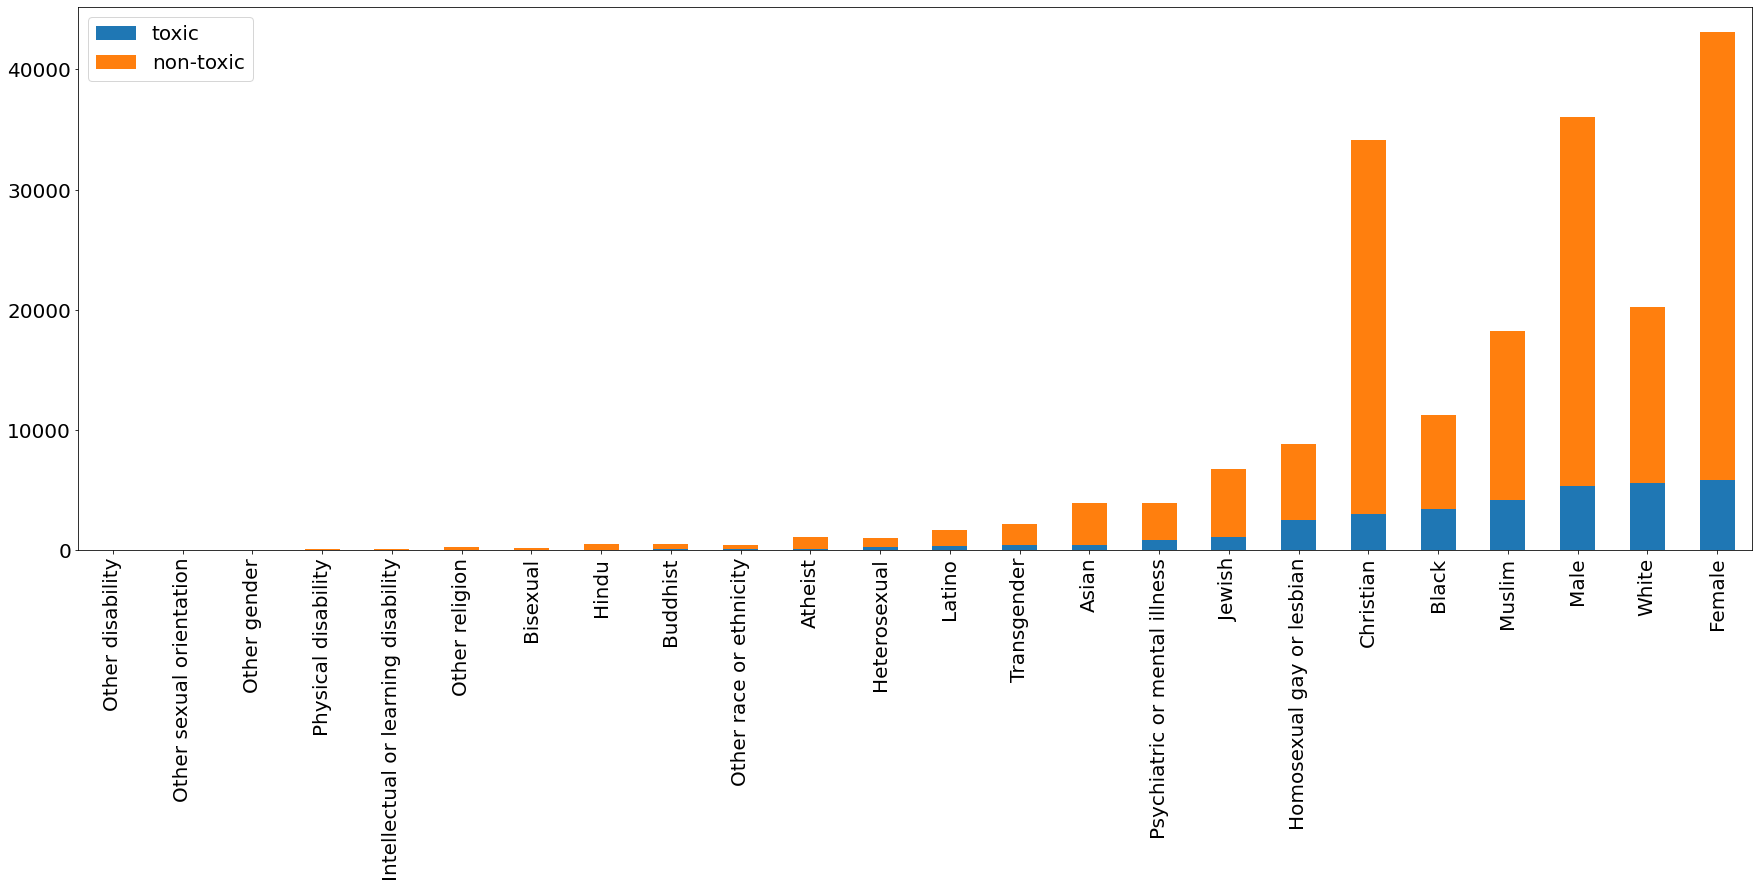

In [408]:
# now we can concat the two series together to get a toxic count vs non toxic count for each identity
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)

toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})

In [3]:
# Showing first few rows of tfidf training data
train_tfidf_data.head()

ID  Toxicity  Asian  Atheist  Bisexual  Black  Buddhist  Christian  Female  \
0   0         0      0        0         0      0         0          0       0   
1   1         1      0        0         0      0         0          1       0   
2   2         1      0        0         0      0         0          0       1   
3   3         0      0        0         0      0         0          0       0   
4   4         0      0        0         0      0         0          1       0   

   Heterosexual  ...  Unnamed: 1016  Unnamed: 1017  Unnamed: 1018  \
0             0  ...            0.0            0.0            0.0   
1             0  ...            0.0            0.0            0.0   
2             0  ...            0.0            0.0            0.0   
3             0  ...            0.0            0.0            0.0   
4             0  ...            0.0            0.0            0.0   

   Unnamed: 1019  Unnamed: 1020  Unnamed: 1021  Unnamed: 1022  Unnamed: 1023  \
0            0.0            0.0            0.0            0.0       0.000000   
1            0.0            0.0            0.0            0.0       0.000000   
2            0.0            0.0            0.0            0.0       0.000000   
3            0.0            0.0            0.0            0.0       0.176374   
4            0.0            0.0            0.0            0.0       0.000000   

   Unnamed: 1024  Unnamed: 1025  
0            0.0            0.0  
1            0.0            0.0  
2            0.0            0.0  
3            0.0            0.0  
4            0.0            0.0  

[5 rows x 1026 columns]

### Subsetting the dataset for only TFIDF Comment feature values

In [8]:
X_train = train_tfidf_data.iloc[:,26:]
y_train = train_tfidf_data['Toxicity']

X_test = dev_tfidf_data.iloc[:,26:]
y_test = dev_tfidf_data['Toxicity']

## Modeling for Classification of Toxicity in Online Comments

## 1. Random Forest Classsifier (Baseline)

Training Random Forest Classifier with only TFIDF comment feature values.

In [6]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8243333333333334


**ROC Curve**

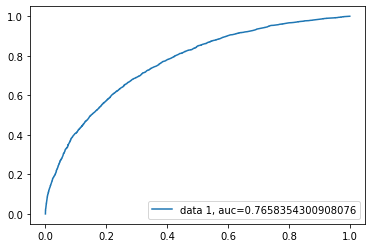

In [8]:
y_pred_proba_RF = clf.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_RF)

auc = metrics.roc_auc_score(y_test, y_pred_proba_RF)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.show()

## 2. MLP Classifier

Training MLP Classifier with only TFIDF comment feature values.

In [21]:
# instantiate the model
clf_MLP = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

# predict 
y_pred_MLP=clf_MLP.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_MLP))

ACCURACY OF THE MODEL:  0.7880666666666667


**ROC Curve**

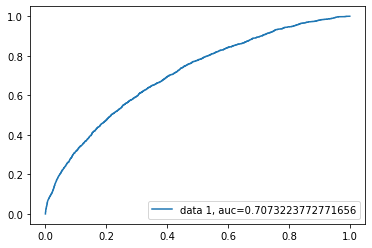

In [23]:
y_pred_proba = clf_MLP.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.show()

## 3. Multinomial Naive Bayes

Training Multinomial Naive Bayes with only TFIDF comment feature values.

In [12]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)

y_pred_NB = clf_NB.predict(X_test)


# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_NB))

ACCURACY OF THE MODEL:  0.8132666666666667


**ROC Curve**

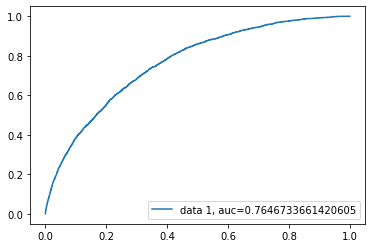

In [14]:
y_pred_proba_NB = clf_NB.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_NB)

auc = metrics.roc_auc_score(y_test, y_pred_proba_NB)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.show()

### Training over all identity categories

Training Baseline model with whole dataset.

In [5]:
y_train_f = train_tfidf_data['Toxicity']
X_train_f = train_tfidf_data.drop(["ID","Toxicity"], axis=1)

y_test_f = dev_tfidf_data['Toxicity']
X_test_f = dev_tfidf_data.drop(["ID","Toxicity"], axis=1)

In [6]:
X_train_f.head()

Asian  Atheist  Bisexual  Black  Buddhist  Christian  Female  Heterosexual  \
0      0        0         0      0         0          0       0             0   
1      0        0         0      0         0          1       0             0   
2      0        0         0      0         0          0       1             0   
3      0        0         0      0         0          0       0             0   
4      0        0         0      0         0          1       0             0   

   Hindu  Homosexual gay or lesbian  ...  Unnamed: 1016  Unnamed: 1017  \
0      0                          0  ...            0.0            0.0   
1      0                          0  ...            0.0            0.0   
2      0                          0  ...            0.0            0.0   
3      0                          0  ...            0.0            0.0   
4      0                          0  ...            0.0            0.0   

   Unnamed: 1018  Unnamed: 1019  Unnamed: 1020  Unnamed: 1021  Unnamed: 1022  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   Unnamed: 1023  Unnamed: 1024  Unnamed: 1025  
0       0.000000            0.0            0.0  
1       0.000000            0.0            0.0  
2       0.000000            0.0            0.0  
3       0.176374            0.0            0.0  
4       0.000000            0.0            0.0  

[5 rows x 1024 columns]

**Training Baseline Model with complete dataset**

In [17]:
# creating a RF classifier
clf_f = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# fit function is used to train the model using the training sets as parameters
clf_f.fit(X_train_f, y_train_f)
 
# performing predictions on the test dataset
y_pred_RF_f = clf_f.predict(X_test_f)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test_f, y_pred_RF_f))


ACCURACY OF THE MODEL:  0.8249333333333333


In [20]:
sub_data = {"index": test_tfidf_data["ID"], "Toxicity": y_pred_lr}
submission = pd.DataFrame(sub_data)
submission.to_csv("submission.csv", index=False)

**Feature Scores** 

Unnamed: 500                           0.025425
Unnamed: 28                            0.014291
Unnamed: 86                            0.009724
Unnamed: 41                            0.008749
Unnamed: 735                           0.008034
                                         ...   
Physical disability                    0.000049
Other gender                           0.000047
Intellectual or learning disability    0.000037
Other sexual orientation               0.000013
Other disability                       0.000011
Length: 1024, dtype: float64

<AxesSubplot:>

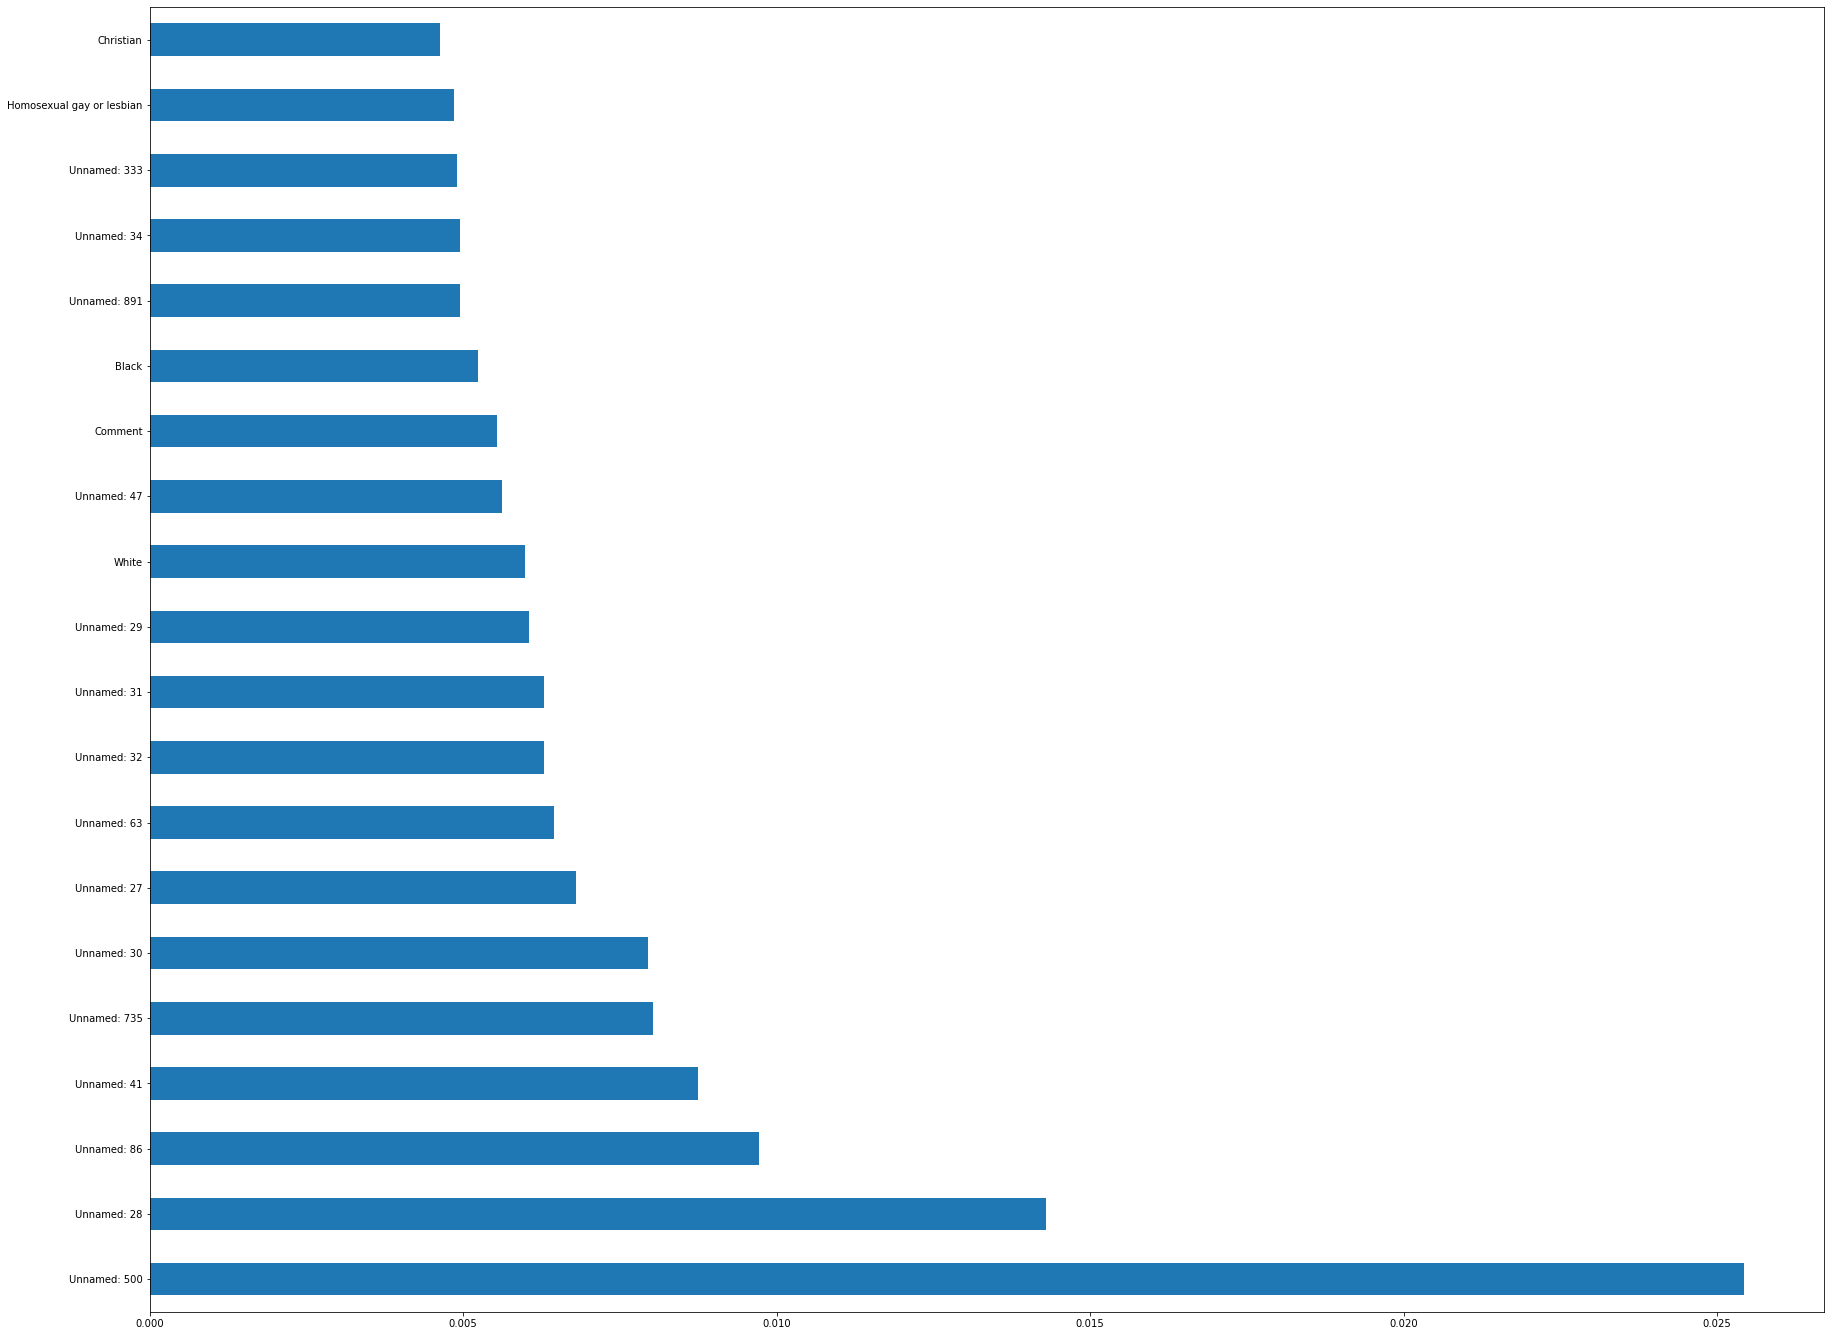

In [18]:
# view the feature scores

feature_scores = pd.Series(clf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=False)

display(feature_scores)
plt.figure(figsize=(30,24))
feat_importances = pd.Series(clf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=False)
feat_importances.nlargest(20).plot(kind='barh')

### Subsetting the dataset for TFIDF Comment feature values + Religion identities (Asian, Atheist,Buddhist, Christian, Hindu, Jewish, Muslim)

In [19]:
X_train_sub0 = train_tfidf_data.iloc[:,26:]
X_train_sub0["Asian"] = train_tfidf_data["Asian"]
X_train_sub0["Atheist"] = train_tfidf_data["Atheist"]
X_train_sub0["Buddhist"] = train_tfidf_data["Buddhist"]
X_train_sub0["Christian"] = train_tfidf_data["Christian"]
X_train_sub0["Hindu"] = train_tfidf_data["Hindu"]
X_train_sub0["Jewish"] = train_tfidf_data["Jewish"]
X_train_sub0["Muslim"] = train_tfidf_data["Muslim"]
# ['Asian', 'Atheist','Buddhist', 'Christian', 'Hindu', 'Jewish', 'Muslim']
y_train_sub0 = train_tfidf_data['Toxicity']

X_test_sub0 = dev_tfidf_data.iloc[:,26:]
X_test_sub0["Asian"] = dev_tfidf_data["Asian"]
X_test_sub0["Atheist"] = dev_tfidf_data["Atheist"]
X_test_sub0["Buddhist"] = dev_tfidf_data["Buddhist"]
X_test_sub0["Christian"] = dev_tfidf_data["Christian"]
X_test_sub0["Hindu"] = dev_tfidf_data["Hindu"]
X_test_sub0["Jewish"] = dev_tfidf_data["Jewish"]
X_test_sub0["Muslim"] = dev_tfidf_data["Muslim"]
y_test_sub0 = dev_tfidf_data['Toxicity']

**Training Baseline Model with a subset of dataset**

In [20]:
# creating a RF classifier
clf_sub0 = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# fit function is used to train the model using the training sets as parameters
clf_sub0.fit(X_train_sub0, y_train_sub0)
 
# performing predictions on the test dataset
y_pred_RF_sub0 = clf_sub0.predict(X_test_sub0)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test_sub0, y_pred_RF_sub0))


ACCURACY OF THE MODEL:  0.8237333333333333


**Feature Scores**

In [21]:
# view the feature scores

feature_scores = pd.Series(clf_sub0.feature_importances_, index=X_train_sub0.columns).sort_values(ascending=False)

feature_scores

Unnamed: 500    0.025617
Unnamed: 28     0.017786
Unnamed: 41     0.012309
Unnamed: 86     0.010435
Unnamed: 63     0.009311
                  ...   
Unnamed: 960    0.000130
Unnamed: 832    0.000125
Unnamed: 923    0.000104
Unnamed: 971    0.000098
Unnamed: 936    0.000097
Length: 1007, dtype: float64

**ROC Curve**

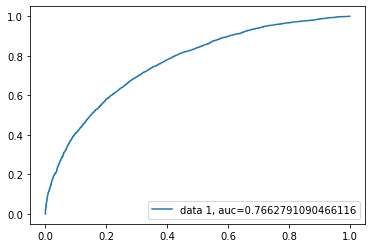

In [24]:
y_pred_proba_RF_sub0 = clf_sub0.predict_proba(X_test_sub0)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_RF_sub0)

auc = metrics.roc_auc_score(y_test, y_pred_proba_RF_sub0)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.show()

### Subsetting the dataset for TFIDF Comment feature values + Gender identities (Male, Female, Transgender, Other gender)

In [25]:
X_train_sub1 = train_tfidf_data.iloc[:,26:]
X_train_sub1["Male"] = train_tfidf_data["Male"]
X_train_sub1["Female"] = train_tfidf_data["Female"]
X_train_sub1["Transgender"] = train_tfidf_data["Transgender"]
X_train_sub1["Other gender"] = train_tfidf_data["Other gender"]

y_train_sub1 = train_tfidf_data['Toxicity']

X_test_sub1 = dev_tfidf_data.iloc[:,26:]
X_test_sub1["Male"] = dev_tfidf_data["Male"]
X_test_sub1["Female"] = dev_tfidf_data["Female"]
X_test_sub1["Transgender"] = dev_tfidf_data["Transgender"]
X_test_sub1["Other gender"] = dev_tfidf_data["Other gender"]
y_test_sub1 = dev_tfidf_data['Toxicity']

**Training Baseline Model with a subset of dataset**

In [26]:
# creating a RF classifier
clf_sub1 = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# fit function is used to train the model using the training sets as parameters
clf_sub1.fit(X_train_sub1, y_train_sub1)
 
# performing predictions on the test dataset
y_pred_RF_sub1 = clf_sub1.predict(X_test_sub1)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test_sub1, y_pred_RF_sub1))


ACCURACY OF THE MODEL:  0.8246


**Feature Scores**

In [27]:
# view the feature scores

feature_scores = pd.Series(clf_sub1.feature_importances_, index=X_train_sub1.columns).sort_values(ascending=False)

feature_scores

Unnamed: 500    0.025846
Unnamed: 28     0.017996
Unnamed: 41     0.012281
Unnamed: 86     0.010522
Unnamed: 63     0.009307
                  ...   
Unnamed: 832    0.000123
Unnamed: 923    0.000110
Unnamed: 971    0.000104
Unnamed: 936    0.000097
Other gender    0.000042
Length: 1004, dtype: float64

#### Summarising Random Forest(Baseline), Logistic Regression and Naive Bayes accuracies for classifying toxicity in online comments on training with various subsets of dataset.

In [24]:
x1 = PrettyTable()
x1.field_names = ["Model", "Accuracy"]

x1.add_row(["Random Forest - Baseline(TFIDF values):", 0.8243])
x1.add_row(["Random Forest - Baseline(Whole Dataset):", 0.8249])
x1.add_row(["Random Forest - Baseline(TFIDF + Religion):", 0.8237])
x1.add_row(["Random Forest - Baseline(TFIDF + Gender):", 0.8246])
x1.add_row(["MLP Classifier (TFIDF values):", 0.7880])
x1.add_row(["Multinomial Naive Bayes(TFIDF values):", 0.8132])

print(x1)

+---------------------------------------------+----------+
|                    Model                    | Accuracy |
+---------------------------------------------+----------+
|   Random Forest - Baseline(TFIDF values):   |  0.8243  |
|   Random Forest - Baseline(Whole Dataset):  |  0.8249  |
| Random Forest - Baseline(TFIDF + Religion): |  0.8237  |
|  Random Forest - Baseline(TFIDF + Gender):  |  0.8246  |
|        MLP Classifier (TFIDF values):       |  0.788   |
|    Multinomial Naive Bayes(TFIDF values):   |  0.8132  |
+---------------------------------------------+----------+


**Hypotheses formulation:** </br>
Three machine learning models are used namely Random Forest, Logistic Regression, and Multinomial Naive Bayes. Random Forest is used as baseline model to experiment with various subsets of dataset keeping other two machine learning models to only train with single subset of dataset. All three models are trained on TFIDF comment feature values and Random Forest performed well than others with a testing accuracy of 82.49% while MLP Classifier has 78.88% and Multinomial Naive Bayes has 81.32%.

Additionally, few experiments conducted with baseline model for different subsets of datasets. Firstly the model trained with all identities and tfidf feature values which gave testing accuracy of 82.49%. Secondly the baseline model trained with tfidf feature values + religion identities and yielded testing accuracy of 82.37%. Lastly the baseline model trained with tfidf feature values + gender identities and yielded testing accuracy of 82.46%. The Baseline model performed well on all identities + tfidf feature values and also on only gender identity + tfidf values as shown in above accuracy table.


**What are the strength and weaknessses of each machine learning paradigms?**</br>
**Random Forest**</br>
**Strengths:** Decision trees are capable of learning non-linear correlations and are somewhat resistant to outliers. In reality, ensembles perform well, winning several conventional (non-deep-learning) machine learning contests.</br>
**Weaknesses:** Individual trees are prone to overfitting when left unconstrained because they might keep branching until they recall the training data. This can be mitigated by employing ensembles.

**MLP Classifier**</br>
**Strengths:** Multilayer Perceptrons have the advantage of learning non-linear models and the ability to train models in real-time (online learning).</br>
**Weaknesses:**</br>
MLP include too many parameters because it is fully connected.Each node is connected to another in a very dense web — resulting in redundancy and inefficiency.

**Multinomial Naive Bayes**</br>
**Strengths:** Even though the conditional independence assumption is rarely valid, NB models perform fairly well in practise, especially given their simplicity. They are simple to implement and may expand with your data.</br>
**Weaknesses:** Because of their simplicity, NB models are frequently outperformed by models properly trained and tweaked utilising the preceding approaches.

**How to adapt the models to close performance gap?**</br>
You need to collect relevant data for training, and deploy pipelines that will feed data to the model when it is in production.

**Which features are most predictive for the task?**</br>
When training baseline model on all identities + tfidf feature values meaning complete dataset we find features that are more important in algorithm's decision making which are: Unnamed: 500, Unnamed: 28, Unnamed: 41, Unnamed: 86, Unnamed: 63,Unnamed: 735, White, Comment, Black, Christian, and homosexual gay or lesbian. When trained baseline model with a subset of dataset including tfidf values + gender identity the important features were: Unnamed: 500, Unnamed: 28, Unnamed: 41, Unnamed: 86, Unnamed: 63,Unnamed: 735, other gender.

**Does method X outperform method Y on the task of comment toxicity because of theoretical property Z.**</br>
The baseline model trained on complete dataset outperformed the baseline models trained on subsets of datasets because of all the features (all identities) were present in the complete dataset.

**Ethical Concerns:**</br>
If the model trained on biased data or on less data it will make an unjust or prejudicial distinction in the treatment of different categories of people, especially on the grounds of race, sex, age, or disability. To mitigate such event the algorithm must be feed with unbiased and complete data which represents every aspect of the community.

## Research Question 1: Does Unlabeled data improve comment toxicity classification?

### Using Unsupervised Algorithms for Toxicity Classification in Online Comments

### 1. DBSCAN clustering algorithm

In [496]:
# Training DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(YY, labels))
print("Completeness: %0.3f" % metrics.completeness_score(YY, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(YY, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(YY, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(YY, labels)
)

Estimated number of clusters: 39
Estimated number of noise points: 138807
Homogeneity: 0.002
Completeness: 0.012
V-measure: 0.004
Adjusted Rand Index: 0.005
Adjusted Mutual Information: 0.003


#### DBSCAN Evaluation

In [499]:
# Calculating Accuracy
# y_true = dev_raw_data['Toxicity']
# l = len(y_true)
l = len(y_test)
acc = sum([db.labels_[i]==y_test[i] for i in range(l)])/l
print("Test Accuracy: ",acc)

Test Accuracy:  0.0017333333333333333


### 2. Gaussian Mixture Model

In [498]:
# Training GMM
# x = x.toarray()
gm = GaussianMixture(n_components=2, random_state=0).fit(X_train)
gm.means_

array([[0.0120581 , 0.02634295, 0.00764032, ..., 0.00725932, 0.0589234 ,
        0.09135615],
       [0.03997351, 0.03049004, 0.03508613, ..., 0.00224874, 0.04441736,
        0.14293678]])

#### Evaluation

In [500]:
#test = test.toarray()
y_pred_gm = gm.predict(X_test)

# Calculating Accuracy
# y_true = dev_raw_data['Toxicity']
l = len(y_test)
acc = sum([y_pred_gm[i]==y_test[i] for i in range(l)])/l
print("Test Accuracy: ",acc)

Test Accuracy:  0.3604


### 3. K-Means Clustering Algorithm

In [501]:
# Training K-Means
rng = RandomState(42)

kmeans = KMeans(2, random_state=rng).fit(X_train)

np.round(kmeans.cluster_centers_, decimals=2)

array([[0.04, 0.03, 0.04, ..., 0.  , 0.04, 0.14],
       [0.01, 0.03, 0.01, ..., 0.01, 0.06, 0.09]])

#### Evaluation

In [503]:
# Training Accuracy
#y_true = dev_raw_data['Toxicity']
l = len(y_test)
acc = sum([kmeans.labels_[i]==y_test[i] for i in range(l)])/l
print("Test Accuracy: ",acc)

Test Accuracy:  0.7376


### Answering Research Question#1:

**The accuracy obtained from using unlabelled data to train unsupervised learning algorithms is far less than that of labelled data with supervised learning algorithms due to lot of variance in the distributaion of toxicity in different identities. Also a huge amount of sparse data is present in the dataset which makes it harder for unsupervised algorithms to draw a line, a common problem in machine learning is sparse data, which alters the performance of machine learning algorithms and their ability to calculate accurate predictions. The result is less accurate as we do not have any input data to train from. The model is learning from raw data without any prior knowledge. It is also a time-consuming process.**

In [28]:
x = PrettyTable()
x.field_names = ["Model", "Accuracy"]

x.add_row(["DBSCAN clustering algorithm:", 0.0017])
x.add_row(["Gaussian Mixture Model:", 0.3604])
x.add_row(["K-Means Clustering Algorithm:", 0.7376])

print(x)

+-------------------------------+----------+
|             Model             | Accuracy |
+-------------------------------+----------+
|  DBSCAN clustering algorithm: |  0.0017  |
|    Gaussian Mixture Model:    |  0.3604  |
| K-Means Clustering Algorithm: |  0.7376  |
+-------------------------------+----------+
